### Unsupervised clustering techniques

This notebook is intended for self-learning a few different unsupervised techniques(for unlabeled data) that can be used for clustering and data exploration. These algorithms are accompanied by graphs to illustrate and support the results of the algorithms.

Three techniques are explored:
1. Hirerchial clustering
2. PCA
3. Kmeans

In this notebook, the USArrests.csv is used. The original csv file can be found here - https://www.kaggle.com/deepakg/usarrests/activity.

This data consists of the following:
Statistics in arrests per 100k residents in each of the 50 US states in 1973 for 3 parameters: Assault, Murder and Rape. Also given is the percent of the population living in urban areas.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("USArrests.csv",index_col=0)
df.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


Scaling the data using StandardScaler. 

The raw features are decreased by the mean and divided by the standard deviation. This is a widely used scaling technique. 

\begin{equation}
x_{scaled\:}\:=\:\frac{x-\mu }{\sigma }
\end{equation}

In [3]:
scaler = StandardScaler()
df_standarized = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index=df.index)
df_standarized.head()

,Murder,Assault,UrbanPop,Rape
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814


### Hierarchical clustering

This is an iterative clustering technique that creates a dendrogram representation of the data without knowing the number of clusters preemptively. This technique uses a distances matrix between the data points. The distance metric could be: 

1. Euclidean - \begin{equation} \|a-b \|_2 = \sqrt{\sum_i (a_i-b_i)^2} \end{equation}
2. Manhattan - \begin{equation} \|a-b \|_1 = \sum_i |a_i-b_i|  \end{equation}
3. Mahalanobis - \begin{equation} \sqrt{(a-b)^{\top}S^{-1}(a-b)} \end{equation} ( S is the covariance matrix)


Initially, it assigns each data point to a cluster. Similar clusters are merged and a new distance matrix is calculated again. These steps can be repeated until a pre-defined number of clusters is achieved.

There are a few common linkage criterias (which define the way we calculate the distance between clusters). Three of them for example:
 1. Complete linkage - among all distances between data-points of 2 clusters, the **max** distance is the distance between the 2 clusters.
 \begin{equation} \max \, \{\, d(a,b) : a \in A,\, b \in B \,\} \end{equation}
 
 
 2. Single - among all distances between data-points of 2 clusters, the **min** distance is the distance between the 2 clusters.
 \begin{equation} \min \, \{\, d(a,b) : a \in A,\, b \in B \,\} \end{equation}
 
 
 3. Unweighted Average linkage - the distance between 2 clusters is the average distance between all data-points in the 2 clusters.
 \begin{equation} \frac{1}{|A|\cdot|B|} \sum_{a \in A }\sum_{ b \in B} d(a,b) \end{equation}

Let us use hierarchical clustering in order to cluster the states. We will use complete linkage and Euclidean distance

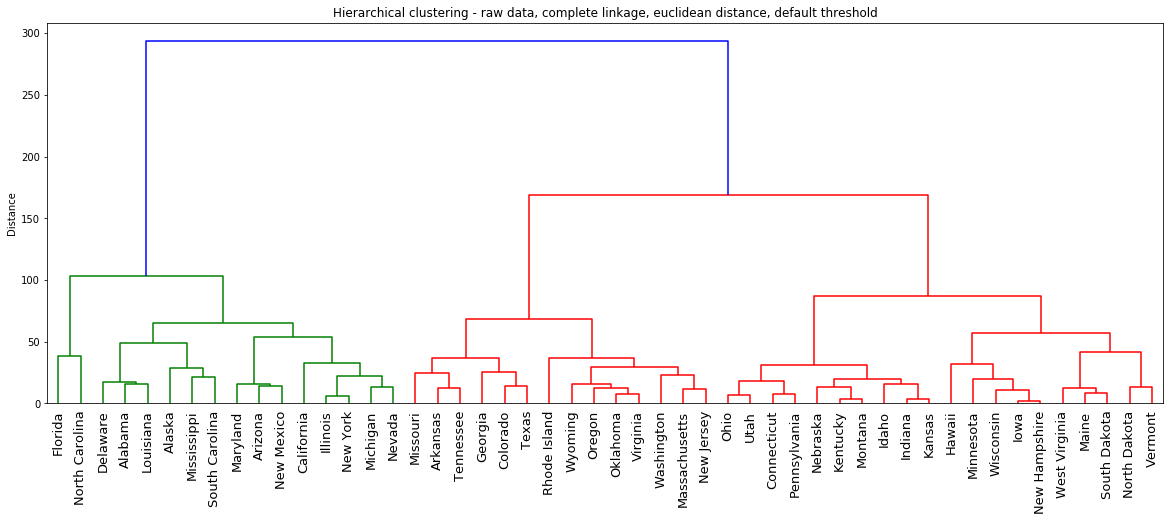

In [4]:
plt.figure(figsize=(20,7))
Z = linkage(df, 'complete', metric='Euclidean')
dendrogram(
    Z,
    color_threshold = None, # Defines the color threshold 0.7*max(Z[:,2]) where above it has the same color(blue)
    leaf_font_size=13.,  # font size for the x axis labels
    labels = df.index
)
plt.title("Hierarchical clustering - raw data, complete linkage, euclidean distance, default threshold")
plt.ylabel("Distance")
plt.show()

We get 2 clusters for this settings. However, we could change the color_threshold value (the distance from which above this value it's only blue color) in order to get different number of clusters. 

For example, changing color_threshold to 90 returns 4 clusters as follows

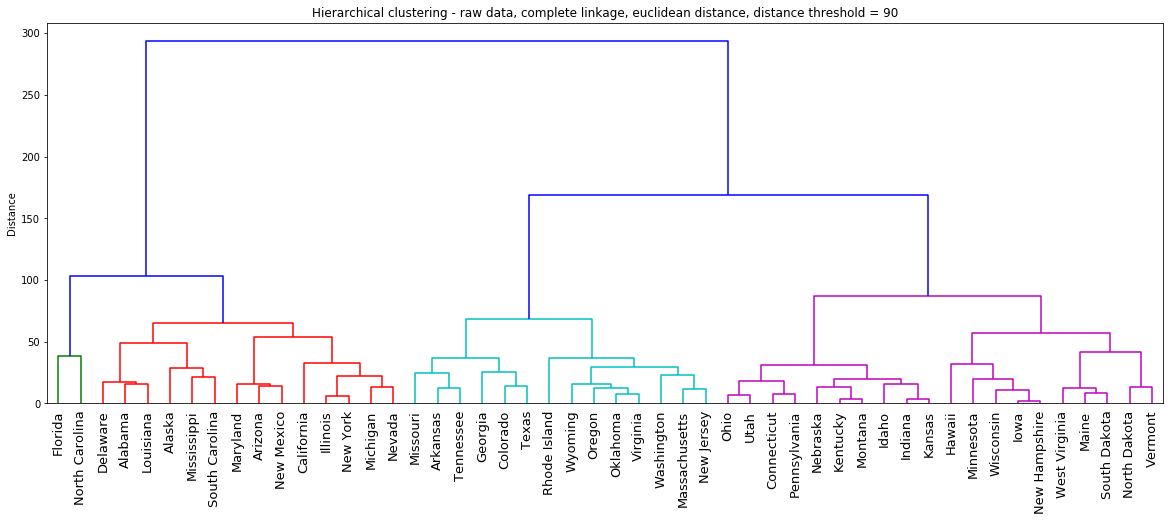

In [5]:
plt.figure(figsize=(20,7))
Z = linkage(df, 'complete', metric='Euclidean')
dendrogram(
    Z,
    leaf_font_size=13.,  # font size for the x axis labels
    color_threshold = 90,#Cut height
    labels = df.index
)
plt.title("Hierarchical clustering - raw data, complete linkage, euclidean distance, distance threshold = 90")
plt.ylabel("Distance")
plt.show()

Let's see the states distribution in the different clusters

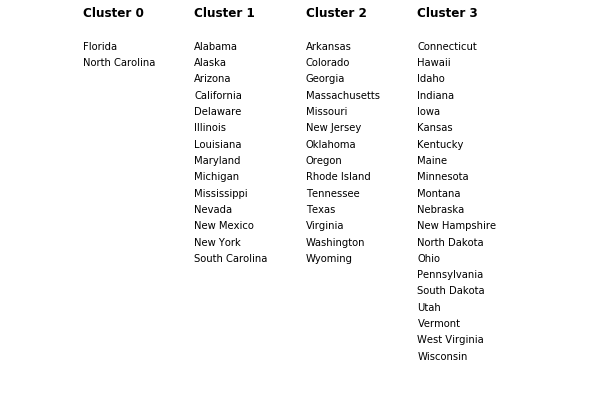

In [6]:
def plot_clusters(num_clusters, df, clusters, alg='kmeans'):
    """
    Plots the k-clusters of a given data 
    """
    start_y = 10
    x_locs = [1 + 2*x for x in range(num_clusters)]
    y_locs = [start_y for x in range(num_clusters)]
    plt.figure(figsize=(10,6))
    df['clusters_{}'.format(alg)] = clusters
    for state in list(df.index):
        ind = int(df.loc[state]['clusters_{}'.format(alg)])
        x = x_locs[ind-1]
        y = y_locs[ind-1]
        plt.text(x, y, state)
        y_locs[ind-1]-=0.5
    for ind, x in enumerate(x_locs):
        plt.text(x, 1+start_y, "Cluster {}".format(ind), fontsize=12, fontweight='bold')
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.axis('off')
    plt.show()

clusters = fcluster(Z, 90, criterion='distance')
plot_clusters(4, df.copy(), clusters, alg='hierarchical')

As seen above, there are 4 clusters in which the purple one is the largest (20 states), the light blue and red are after it (14 states) and the green one is the smallest (2 states). Note that the green cluster could be inserted into the red cluster, but we will leave it as is for now.

Let's take another look at our data. We can visualize the features  (Murder, UrbanPop, Rape and Assault) on the US map. This would allow us more easily to identify areas of a bunch of states which have higher/lower rates of a single feature. This can support the dendrogram resultsץ

First we create another df with the states abbreviations as an index

In [7]:
us_state_abbrev = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}
states_df = pd.DataFrame(us_state_abbrev, index=us_state_abbrev.keys())
states_df = states_df.head(1).T
states_df.columns = ["abbr"]
df_with_states = pd.merge(df_standarized, states_df, left_index=True, right_index=True)
df_with_states.index = df_with_states.abbr
df_with_states.drop(labels='abbr', axis=1, inplace=True)
# df1["states"] = us_state_abbrev[df1.index]

In [8]:
df_with_states.head()

,Murder,Assault,UrbanPop,Rape
abbr,,,,
AL,1.255179,0.790787,-0.526195,-0.003451
AK,0.513019,1.118060,-1.224067,2.509424
AZ,0.072361,1.493817,1.009122,1.053466
AR,0.234708,0.233212,-1.084492,-0.186794
CA,0.281093,1.275635,1.776781,2.088814


And now we visualize each feature (Murder, UrbanPop, Rape and Assault) on the US map using bokeh

In [24]:
from bokeh.plotting import figure, show, output_file
from bokeh.sampledata.us_counties import data as counties
from bokeh.sampledata.us_states import data as states
from bokeh.sampledata.unemployment import data as unemployment
from bokeh.io import output_notebook

# Deleting far states (that are not in America continent)
del states["HI"]
del states["AK"]


state_xs = [states[code]["lons"] for code in states]
state_ys = [states[code]["lats"] for code in states]

colors = ["#F1EEF6", "#D4B9DA", "#C994C7", "#DF65B0", "#DD1C77", "#980043"]

# A function to interpolate the values on a scale between 0 to len(colors)
make_interpolation = lambda x, col: (len(colors)-1) * (x[col] - x[col].min()) / (x[col].max() - x[col].min())

state_colors_rape = []
state_colors_murder = []
state_colors_assault = []
state_colors_pop = []
county_colors=[]
for state_id in states:
    try:
        rate_rape = make_interpolation(df_with_states, 'Rape').loc[state_id]
        state_colors_rape.append(colors[int(rate_rape)])
        
        rate_murder = make_interpolation(df_with_states, 'Murder').loc[state_id]
        state_colors_murder.append(colors[int(rate_murder)])
        
        rate_assault = make_interpolation(df_with_states, 'Assault').loc[state_id]
        state_colors_assault.append(colors[int(rate_assault)])
        
        rate_pop = make_interpolation(df_with_states, 'UrbanPop').loc[state_id]
        state_colors_pop.append(colors[int(rate_pop)])
    except KeyError:
        state_colors_rape.append("white")
        state_colors_murder.append("white")
        state_colors_assault.append("white")
        state_colors_pop.append("white")


p1 = figure(title="US Murder", toolbar_location="left",
           plot_width=600, plot_height=400)

p1.patches(state_xs, state_ys, fill_alpha=0.7, fill_color=state_colors_murder,
          line_color="#884444", line_width=2, line_alpha=0.3)

p2 = figure(title="US Rape", toolbar_location="left",
           plot_width=600, plot_height=400)

p2.patches(state_xs, state_ys, fill_alpha=0.7, fill_color=state_colors_rape,
          line_color="#884444", line_width=2, line_alpha=0.3)

p3 = figure(title="US Assault", toolbar_location="left",
           plot_width=600, plot_height=400)

p3.patches(state_xs, state_ys, fill_alpha=0.7, fill_color=state_colors_assault,
          line_color="#884444", line_width=2, line_alpha=0.3)

p4 = figure(title="US Urban Population", toolbar_location="left",
           plot_width=600, plot_height=400)

p4.patches(state_xs, state_ys, fill_alpha=0.7, fill_color=state_colors_pop,
          line_color="#884444", line_width=2, line_alpha=0.3)

show(p1)
show(p2)
show(p3)
show(p4)
output_notebook()

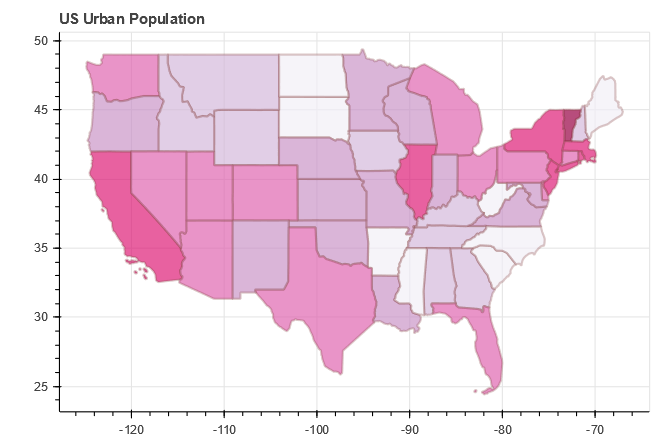

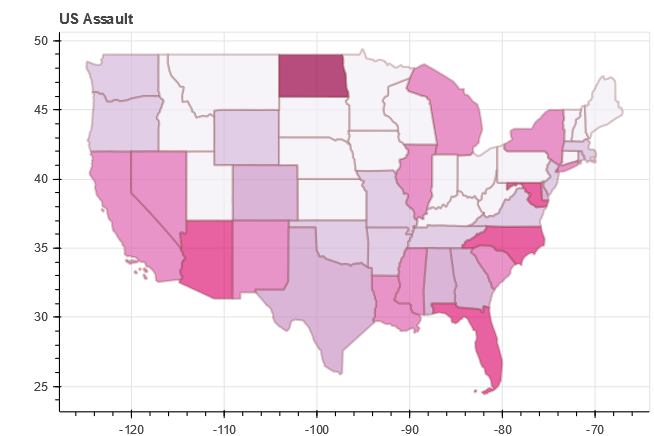

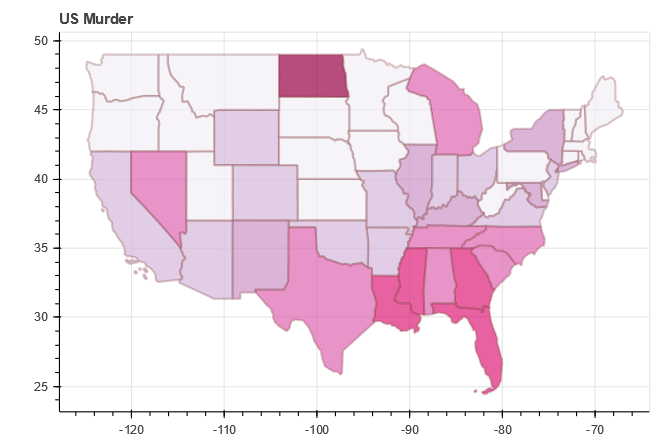

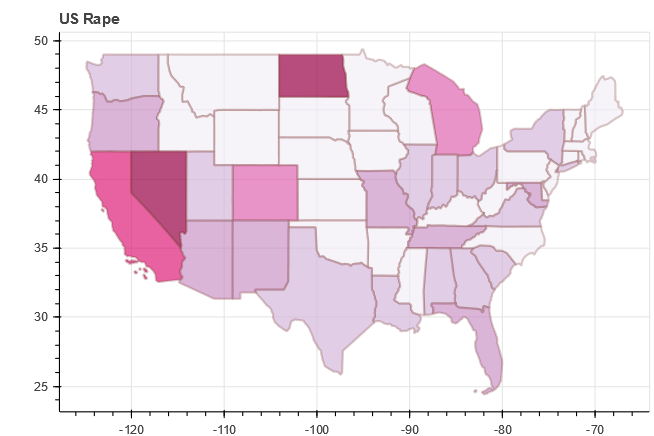

In [10]:
from IPython.display import Image
display(Image(filename='UrbanPop.png'))
display(Image(filename='Assault.png'))
display(Image(filename='Murder.png'))
display(Image(filename='Rape.png'))

A concrete example: 

As seen above, there are high rates of murder in the southeastern countries of the US. This may support the results of the dendogram in which Louisiana, Mississippi, Alabama, South Carolina and Tennessee are in the same cluster (red). Also, the rape rates there are pretty low in most of them. 

However, Florida, also a state in the southeastern part of the US, is not in the same cluster, this can be shown also in the heat maps above (note the difference between Florida and the states next to it in the "US Urban Population" and "US Assault" maps).


### Hierarchical algorithm (same settings as before) on scaled data

In [10]:
df_standarized.describe()

,Murder,Assault,UrbanPop,Rape
count,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01
mean,-8.437695e-17,1.298961e-16,-4.263256e-16,8.326673e-16
std,1.010153e+00,1.010153e+00,1.010153e+00,1.010153e+00
min,-1.620693e+00,-1.524362e+00,-2.340661e+00,-1.502548e+00
25%,-8.611383e-01,-7.486054e-01,-7.704502e-01,-6.640245e-01
50%,-1.247758e-01,-1.425453e-01,3.210209e-02,-1.220847e-01
75%,8.029251e-01,9.483628e-01,8.521012e-01,5.330962e-01
max,2.229265e+00,2.015028e+00,1.776781e+00,2.671197e+00


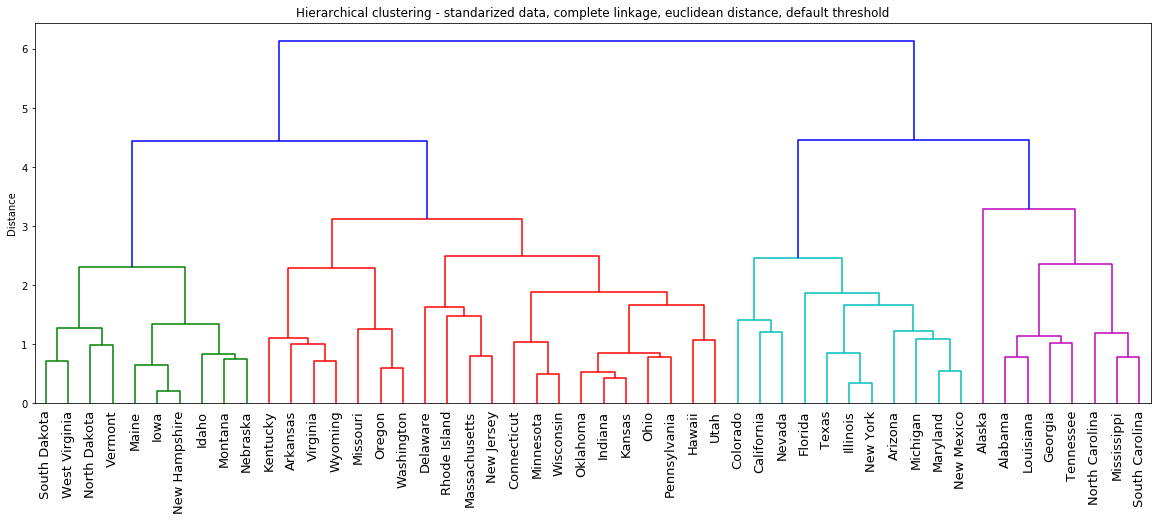

In [11]:
plt.figure(figsize=(20,7))
Z = linkage(df_standarized, 'complete', metric='Euclidean')
dict_dend = dendrogram(
    Z,
    leaf_font_size=13.,  # font size for the x axis labels
    labels = df_standarized.index,
)
plt.title("Hierarchical clustering - standarized data, complete linkage, euclidean distance, default threshold")
plt.ylabel('Distance')
plt.show()

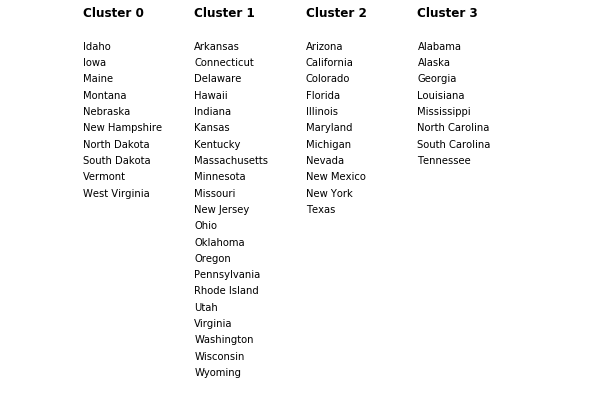

In [12]:
clusters = fcluster(Z, 0.7*max(Z[:,2]), criterion='distance')
df_stand_with_clusts = df_standarized.copy()
df_stand_with_clusts['clusters_hierarchical'] = clusters
plot_clusters(4, df_stand_with_clusts.copy(), clusters)

Now we get 4 clusters for the default color_threshold dendrogram (we got 2 before).
This is due to the fact that we use Euclidean distance as our distance metric. Euclidean distance is a simple metric that is highly affected by the variance of the features. Prior to standardization, we have features with different scales (with different mean and variance) therefore the results are affected by this variance distances.
Scaling the features to have std = 1 cures this phenomena.

An Illustration of scaling (note that the order of data points stays the same, but the x and y scales changes):

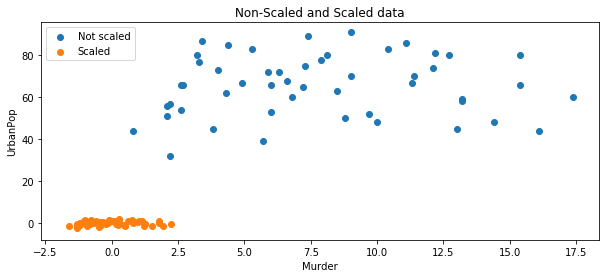

In [13]:
plt.figure(figsize=(10,4))
plt.scatter(x=df.Murder, y=df.UrbanPop, label="Not scaled")
plt.scatter(x=df_standarized.Murder, y=df_standarized.UrbanPop, label="Scaled")
plt.title("Non-Scaled and Scaled data")
plt.xlabel("Murder")
plt.ylabel("UrbanPop")
plt.legend()
plt.show()


### KMeans

Another clustering technique that is similar to KNN algorithm (which is used for classification). This iterative algorithm has to be given the number of clusters preemptively and an initial clusters assignment for each data point (could be random). In each iteration, the centroids of all clusters are calculated as well as the distances from all data points to those centroids (any distance metric could be used here) and the objective is to minimize the sum of distances between data points within a cluster (It's the same as: maximize the sum of distances between data points between different clusters).
\begin{equation}
argmin\left(\sum _{j=1}^k\sum _{x_i\in \:Sj}\left|x_i-\mu _j\right|^2\right)\:where\:S_j\:is\:the\:j^{th\:}cluster\:of\:points\:
\end{equation}
After a pre-defined number of iterations we get the final clusters assingments. It is important to note that if the initial clusters assignment is random, the final result may be different in different runs.

We will use the euclidean distance on the standardized data.

In [14]:
def Kmeans(num_clusters, epochs, df):
    
    # Random initial class assignments
    clusters = np.random.randint(0, num_clusters, size=df.shape[0])  
    print("Initial clusters assignment: \n {}".format(clusters))
    
    for ind in range(epochs):
        dists = []
        for k in range(num_clusters):

            # Get indices of the current k'th class
            indices = np.where(clusters == k)[0]

            # calculate the centroid of the current k'th class
            centroid = np.mean(df.iloc[indices].values, axis=0)

            if dists is []:  # for the first class
                # Calculate euclidean distances between all points and the k'th class centroid
                dists.append(list(np.sqrt(np.sum(np.square(df.values - centroid), axis=1))))
            else:
                new = np.sqrt(np.sum(np.square(df.values - centroid), axis=1))
                dists.append(new)

        # get min index along axis 0 (all distances), the min index in the closest centroid
        # Note that dists is a numpy array with shape (#classes, #points) so along axis 0 means go through all points.
        clusters = np.argmin(np.array(dists), axis=0)
    return clusters

clusters = Kmeans(4, 150, df_standarized)
print("Final clusters assignment: \n {}".format(clusters))



Initial clusters assignment: 
 [0 3 1 3 3 0 0 1 2 0 3 3 1 1 0 0 3 1 2 1 2 3 1 1 1 0 1 2 0 1 1 0 0 1 2 1 1
 2 3 0 2 1 2 3 3 2 2 2 0 1]
Final clusters assignment: 
 [1 1 1 3 1 1 2 3 1 1 2 0 1 3 0 3 3 1 0 1 2 1 2 1 3 0 3 1 0 2 1 1 1 0 3 3 3
 2 2 1 0 1 1 2 0 3 3 0 0 3]


Let's see those clusters

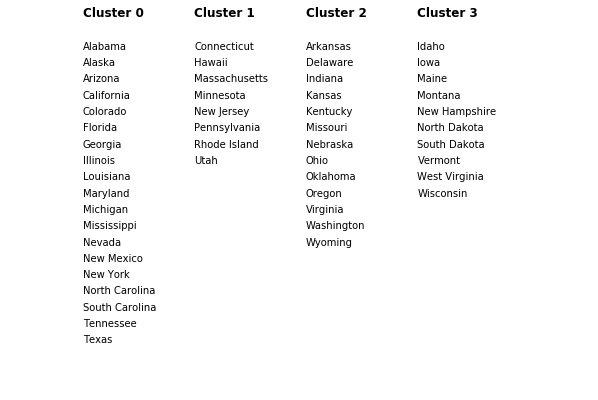

In [15]:
df_stand_with_clusts['clusters_kmeans'] = clusters
plot_clusters(4, df_stand_with_clusts.copy(), clusters, alg="kmeans")

### PCA

Principal Component analysis is a linear transformation that in many cases is used for dimensionality reduction. In simple words: It finds the vectors (called principal components) that best explain the variance in the data. The first vector is the most explaining one, the second vector is the second most explaining etc. 
How it's done:
1. Calculate the covariance matrix.
2. Calculate the eigen vectors and eigen values of the covariance matrix.
3. Re-order the eigen vectors according to their eigen values (DESC).
4. Select number of vectors according to the ratio of explained variance (e.g. 95%)
    This can be done by the following 
    \begin{equation}
    \lambda _{ratio-i}\:=\:\frac{\lambda \:_i}{\sum _{n=0}^N\left(\lambda \:\:_i\right)}
    \end{equation}
5. Organize the new vectors in a matrix A. This is the new lower-dimension data.
Now, we'll run PCA with 2 components. This enables to represent the data in a new basis: the 2 found vectors.

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit(df_standarized.values).transform(df_standarized.values)
explained_ratio = pca.explained_variance_ratio_*100
print("First component explained ratio: {:.1f}%".format(explained_ratio[0]))
print("Second component explained ratio: {:.1f}%".format(explained_ratio[1]))

First component explained ratio: 62.0%
Second component explained ratio: 24.7%


### Visualizing the 2d projection of the data after the PCA
Since our raw data is in 4 dimensions, we could visualize a lower dimension representation of the data with PCA.

We will use the first 2 principal components as our x-axis and y-axis and show the states according to their clusters we got in the KMeans and the Hierarchical algorithms.


In [17]:
def plot_pca_proj(df, features, X_pca, pca, states, inds_states=None, alg='kmeans'):
    """
    Plots PCA data on a 2d projection plot. 
    df: The standarized data with clusters assignment as a feature
    features: Columns names
    X_pca: The data after PCA transformation
    pca: The PCA object
    states: list of states to show
    inds_states: list of indices of the given states in the original data
    alg: name of clustering algorithm that was used
    """
    colors = ['green', 'blue', 'purple', 'brown']

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(1,1,1)
    ax.set_title('PCA - 2d projection visualization - {}'.format(alg))
    ax.set_xlabel('Principal Component 1', fontsize = 10)
    ax.set_ylabel('Principal Component 2', fontsize = 10)

    # Factor to extend the eigen vectors
    factor = 3.
    
    if inds_states is None:
        inds_states = list(range(len(states)))
    for ind, state in enumerate(states):   
        ax.text(X_pca[inds_states[ind], 0], X_pca[inds_states[ind], 0], state, 
                color=colors[int(df.loc[state]['clusters_{}'.format(alg)])-1], alpha=0.7)

    for loc, label in zip(pca.components_.T,list(features)):
        ax.arrow(0,0, loc[0], loc[1], color='r')
        ax.text(loc[0]+0.03, loc[1]-0.03, s="{} ({:.2f},{:.2f})".format(label,loc[0], loc[1]), 
                color = 'b', fontsize=16)

    ax.set_xlim(X_pca[:,0].min()-1.5, X_pca[:,0].max()+1.5)
    ax.set_ylim(X_pca[:,1].min()-1.5, X_pca[:,1].max()+1.5)

    plt.show()

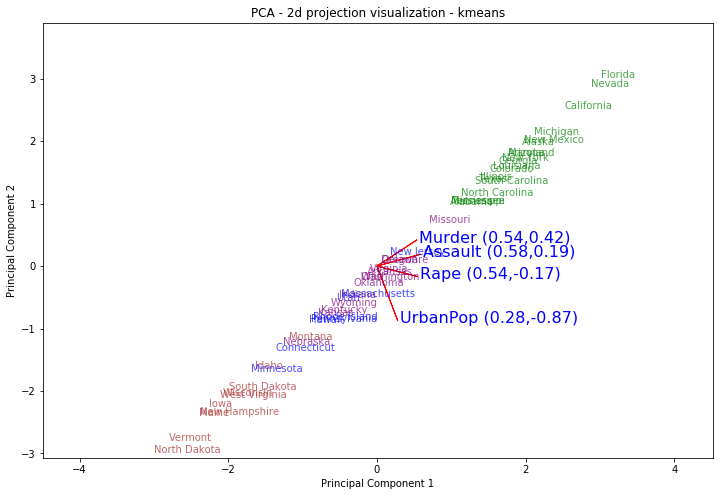

In [18]:
plot_pca_proj(df_stand_with_clusts, df_standarized.columns,X_pca, pca, list(df.index), alg='kmeans')

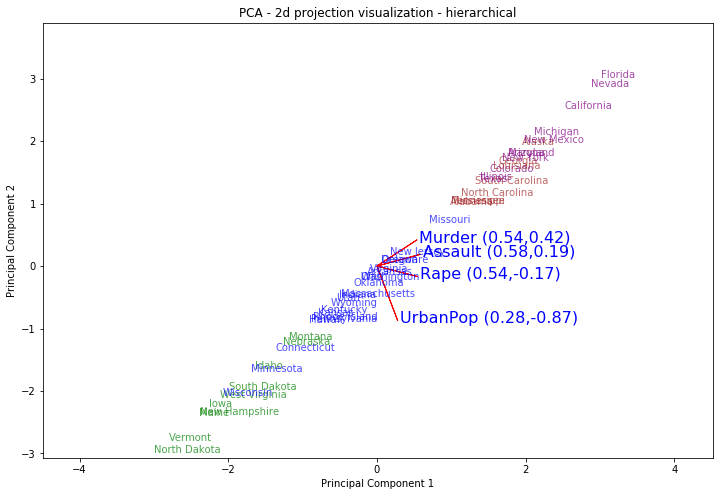

In [19]:
plot_pca_proj(df_stand_with_clusts, df_standarized.columns,X_pca, pca, list(df.index), alg='hierarchical')

In [20]:
pd.DataFrame(pca.components_, columns=df.columns, index=['PC1', 'PC2'])

,Murder,Assault,UrbanPop,Rape
PC1,0.535899,0.583184,0.278191,0.543432
PC2,0.418181,0.187986,-0.872806,-0.167319


The plot above alongside the components table give us the direction of the maximum variance in the data.
One can see that Assault feature has the greatest impact on PC1 (positive) whereas UrbanPop on PC2 (negative).

It's nice to see that the Kmeans clusters are ordered nicely on this 2d plot. This is not a coincidence, as explained in Ding & He paper from 2004 "K-means Clustering via Principal Component Analysis". Both Kmeans and PCA have similar objective functions.

Let's see the same 2d plot only for the states we identified above as closely related to each other (according to the bokeh US maps and the Hierarchical clustering)

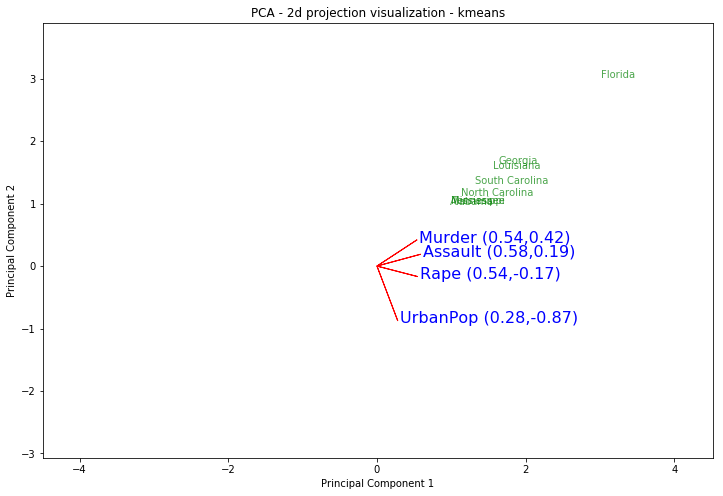

In [21]:
states_to_explore = ['Louisiana', 'Mississippi', 'Alabama', 'Georgia', 'North Carolina',
                     'South Carolina', 'Tennessee', 'Florida']
inds_states = [list(df.index).index(state) for state in states_to_explore]
plot_pca_proj(df_stand_with_clusts, df_standarized.columns,X_pca, pca, states_to_explore, inds_states)

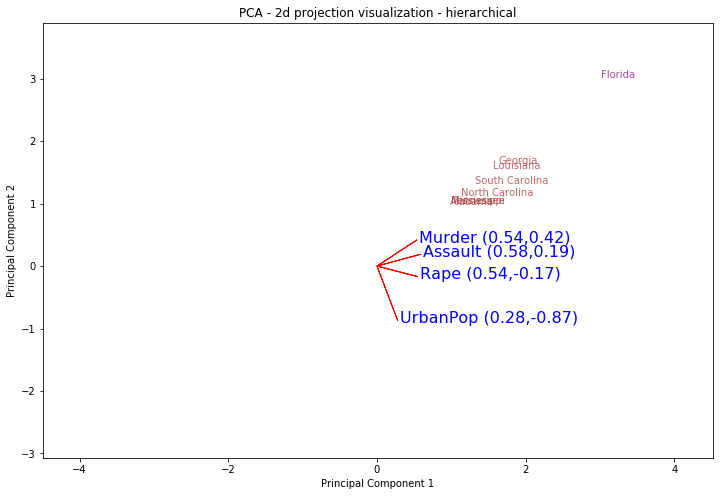

In [22]:
plot_pca_proj(df_stand_with_clusts, df_standarized.columns,X_pca, pca, states_to_explore, inds_states, alg='hierarchical')

Looks familiar. We already a very similar cluster in the Hierarchical clustering which is probably due to the similar murder and rape values these states have.

### Final Remarks


- Kmeans and Hierarchical algorithms were used for clustering the data points into k number of clusters (Here k=4). Kmeans require a pre-defined number of clusters and Heirarchical requires a color_threshold that defines the number of clusters. There are other algorithms out there that do not require parameters that define the number of clusters manually, e.g. DBscan. These kind of clusterin techniques will be explored in a future notebook.

- Kmeans and Hierarchical algorithms return quite similar clusters (Take a look at the plots of all states and at the plots of selected states above, it's almost identical).

- The PCA technique enables us bring the 4d raw data to a lower dimension (2d) and plot it on a simple graph. As seen above, the states are ordered somewhat diagonally. Also, Murder and Assault features are quite correlated as opposed to Murder and UrbanPop (according to the agngles of the vectors in the plots).
